In [ ]:
"""
We will discuss the following models

1. Binary Classifier
2. Multi-Class Classifier
3. Multi-Label Classifier
"""

In [1]:
## Getting classification data ready

from sklearn.datasets import make_circles

n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
# Printing the first 5 X and y values
print(X[:5], y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] [1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


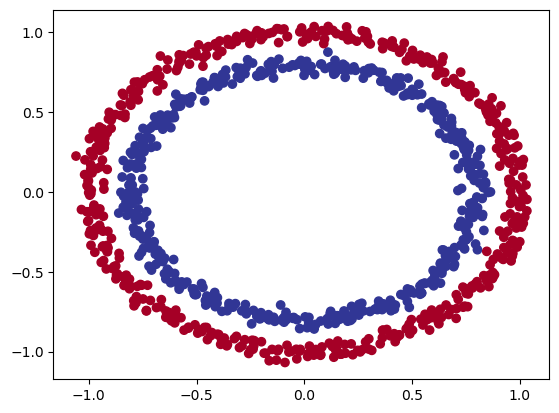

In [5]:
# Let plot them
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
## Turning data into tensors and creating - train,test splits

import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
# Lets build the model for the binary classification 

In [8]:
import torch
from torch import nn

# device agnostic
device = "gpu" if torch.cuda.is_available() else "cpu"

In [10]:
# construct the model class
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Creating two nn.Linear layers capable of handling X and y input and output
        self.layer_1 = nn.Linear(in_features=2, out_features=5)  # this means 5 hidden layers
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
## We can also use the nn.Sequential claas to perform the forward pass

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2807],
        [-0.2730],
        [-0.2992],
        [-0.2754],
        [-0.2967],
        [-0.2920],
        [-0.2725],
        [-0.2769],
        [-0.2992],
        [-0.2725]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
## Setting up loss function and optimizer

In [ ]:
"""
Since this model is a binary classification model, pytorch has  2 binary cross entropy implementations

1. torch.nn.BCELoss() - creates a loss function to mesaure the cross entropy between target and input
2. torch.nn.BCEWithLogitsLoss - same as above except has a sigmoid layer built in.
"""

In [14]:
# Creating a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
### Writing functions for computing evaluation metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [16]:
## Lets train the model

In [20]:
torch.manual_seed(42)

epochs = 100

# Putting the data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test   = X_test.to(device), y_test.to(device)

# Building a training and eval loop
for epoch in range(epochs):
    ## Training
    model_0.train()

    # 1.Forward pass
    y_logits = model_0(X_train).squeeze() # this has the actual values/logits
    y_pred = torch.round(torch.sigmoid(y_logits)) # this will give us 0 / 1 answer

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    # Back Prop
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))


        # calculating loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc  = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss {loss: 5f}, Accuracy : {acc: .2f}% | Test loss: {test_loss: .5f},  Test acc: {test_acc: .2f}%") 


Epoch: 0 | Loss  0.702378, Accuracy :  50.00% | Test loss:  0.70161,  Test acc:  50.00%
Epoch: 10 | Loss  0.696517, Accuracy :  50.00% | Test loss:  0.69545,  Test acc:  50.00%
Epoch: 20 | Loss  0.694678, Accuracy :  50.00% | Test loss:  0.69335,  Test acc:  50.00%
Epoch: 30 | Loss  0.694057, Accuracy :  50.00% | Test loss:  0.69262,  Test acc:  50.00%
Epoch: 40 | Loss  0.693805, Accuracy :  43.00% | Test loss:  0.69239,  Test acc:  48.00%
Epoch: 50 | Loss  0.693668, Accuracy :  46.12% | Test loss:  0.69235,  Test acc:  49.50%
Epoch: 60 | Loss  0.693573, Accuracy :  46.38% | Test loss:  0.69239,  Test acc:  52.50%
Epoch: 70 | Loss  0.693497, Accuracy :  46.25% | Test loss:  0.69246,  Test acc:  52.00%
Epoch: 80 | Loss  0.693432, Accuracy :  46.62% | Test loss:  0.69255,  Test acc:  51.00%
Epoch: 90 | Loss  0.693376, Accuracy :  46.88% | Test loss:  0.69265,  Test acc:  51.00%


In [21]:
# The binary classifier doesn't seem to do well, hence we will want to visualize the decision boundry
# lets fetch this function from a remote github repo.

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [23]:
from helper_functions import plot_predictions, plot_decision_boundary

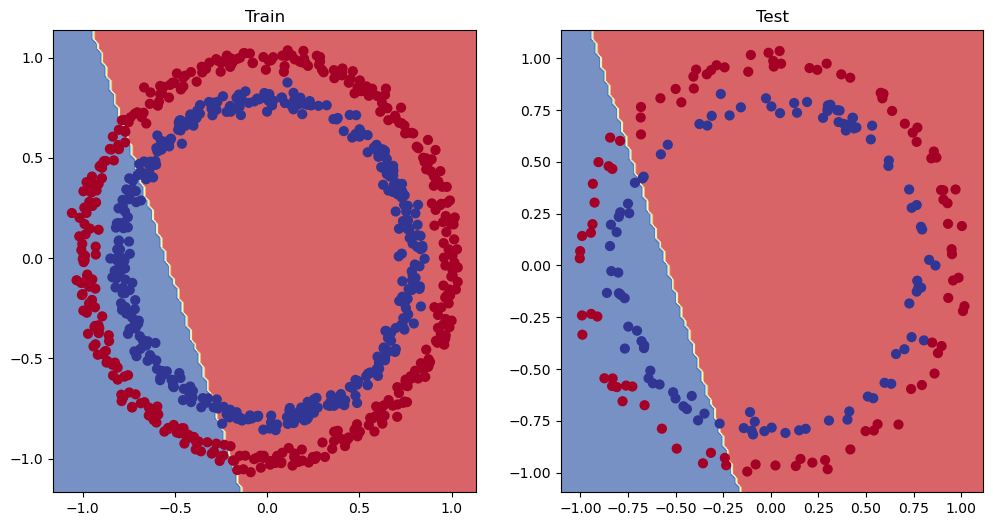

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
## Looks like we found the issue, we are trying to split the red and blue lines using a straight line...since our data is circular 
# i.e non linear, we cannot use a linear model to approximate it.

# Our model is currently under-fitting.

# we will need to introduce some non-linerity to our model - reLU ?

In [27]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)       

TypeError: descriptor '__init__' of 'super' object needs an argument